In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
import pylab as py
import random
import pandas as pd
from matplotlib import gridspec
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from datetime import datetime
import time
import corner
import emcee
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr

In [2]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [3]:
df = pd.read_csv("edd_cf4_refined.csv", sep='|')


for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)

df['D75'] = df.Vmod / 75.
df['logD75'] = np.log10(df.Vmod / 75.)
df['DM_75'] = 5*df.logD75 + 25 
df['Mg_75'] = df['g***'] - df.DM_75
df['Mr_75'] = df['r***'] - df.DM_75
df['Mi_75'] = df['i***'] - df.DM_75
df['Mz_75'] = df['z***'] - df.DM_75
df['M1_75'] = np.asarray([np.float64(x) for x in df['w1'].values]) - df.DM_75.values
df['M2_75'] = np.asarray([np.float64(x) for x in df['w2'].values]) - df.DM_75.values

df['gi'] = df['g***'] - df['i***']
df['rz'] = df['r***'] - df['z***']
df['gz'] = df['g***'] - df['z***']


print(df.columns)
print(len(df))

df.head()

Index(['PGC', 'Name', 'Vhel', 'Vls', 'u', 'g', 'r', 'i', 'z', 'w1',
       ...
       'DM_75', 'Mg_75', 'Mr_75', 'Mi_75', 'Mz_75', 'M1_75', 'M2_75', 'gi',
       'rz', 'gz'],
      dtype='object', length=119)
10737


/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,PGC,Name,Vhel,Vls,u,g,r,i,z,w1,...,DM_75,Mg_75,Mr_75,Mi_75,Mz_75,M1_75,M2_75,gi,rz,gz
0,2,UGC12889,5017.0,5309.5,0.00,0.00,0.00,0.00,0.00,11.86,...,34.024557,-34.024557,-34.024557,-34.024557,-34.024557,-22.164557,-21.534557,0.00,0.00,0.00
1,4,PGC000004,4458.0,4706.1,17.57,16.43,15.91,15.57,15.42,16.06,...,33.717026,-18.127026,-18.387026,-18.597026,-18.647026,-17.657026,-17.297026,0.47,0.26,0.52
2,12,PGC000012,6531.0,6667.6,0.00,0.00,0.00,0.00,0.00,13.60,...,34.620362,-34.620362,-34.620362,-34.620362,-34.620362,-21.020362,-20.420362,0.00,0.00,0.00
3,16,PGC000016,5713.0,5855.1,16.08,14.83,14.21,13.86,13.61,13.98,...,34.281429,-19.921429,-20.421429,-20.701429,-20.881429,-20.301429,-19.611429,0.78,0.46,0.96
4,55,UGC12898,4779.0,5052.2,16.82,16.08,15.71,15.50,15.40,16.18,...,33.894131,-18.364131,-18.574131,-18.674131,-18.724131,-17.714131,-17.294131,0.31,0.15,0.36


In [17]:
def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

[0.35859423 1.64789521]
0.3585942298475359 1.6478952116460055


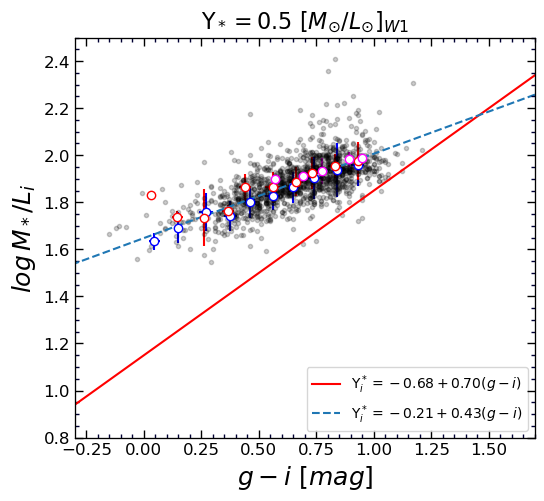

In [18]:
fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1




df['logMs'] =(np.log10(0.5) + 0.4*5.91)-0.4*df['M1_75']+0.4*df['Mi_75']


dff = df[(df.Qs>2)&(df.Qw>0)&(df.gi>-1)&(df.logMs<10)&(df.Vmod>4000)].dropna()

X0 = dff.gi.values
Y0 = dff.logMs.values # +  (0.142*dff.lgWmxi.values - 0.366)
Vmod = dff.Vmod.values

ax.plot(X0, Y0, 'k.', alpha=0.2)


set_axes(ax, (-0.3,1.7), (0.8,2.5), fontsize=12)


def func(x, m, b):
    return m*x+b
    

fit, cov = curve_fit(func, X0, Y0)

linear = odr.Model(f)
mydata = odr.Data(X0, Y0)
myodr = odr.ODR(mydata, linear, beta0=[1,1])
myoutput = myodr.run()
print(myoutput.beta)

m = myoutput.beta[0]
b = myoutput.beta[1]
m0 = fit[0]
b0 = fit[1] 
# m = 1./m
# b = -b*m


gi = np.linspace(-1,2)
ax.plot(gi, 0.7*gi+1.15, 'r-', label=r'$\Upsilon^*_i=-0.68+0.70(g-i)$')
# ax.plot(gi, m0*gi+b0, 'b-', label=r'$\Upsilon_*=-0.68+0.7(g-i)$')
ax.plot(gi, m*gi+b, '--', label=r'$\Upsilon^*_i=-0.21+0.43(g-i)$')

print(m, b)

dff = df[(df.Qs>2)&(df.Qw>0)&(df.gi>-1)&(df.logMs<10)].dropna()
dff['delta'] = (m*dff.gi+b)-dff.logMs
std = dff['delta'].std()
dff = dff[np.abs(dff.delta)<3.5*std]

ax.set_xlabel(r'$g-i \/\/[mag]$', fontsize=18) 
ax.set_ylabel(r'$log \/ M_*/L_{i}$', fontsize=18)
ax.set_title(r'$\Upsilon_*=0.5\/\/ [M_{\odot}/L_{\odot}]_{W1}$', fontsize=16)

ax.legend()



label='4000<Vmod<5000'
ind, = np.where((Vmod>4000)&(Vmod<5000))
X = X0[ind]
Y = Y0[ind]
lab = True
for i in np.arange(0,1,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='blue', ms=6, mfc='white', label=labe)    
        
        
label='9000<Vmod<11000'
lab = True
ind, = np.where((Vmod>9000)&(Vmod<11000))
X = X0[ind]
Y = Y0[ind]
for i in np.arange(0,1,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None   
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='red', ms=6, mfc='white', label=labe)  
        
        
label='15000<Vmod'
lab = True
ind, = np.where((Vmod>9000)&(Vmod<11000))
X = X0[ind]
Y = Y0[ind]        
ind, = np.where((Vmod>15000))
X = X0[ind]
Y = Y0[ind]
for i in np.arange(0,1,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None   
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='magenta', ms=6, mfc='white', label=labe)             
        

In [19]:
dff['delta'].std()

0.07957759288321102